In [271]:
# some ideas just for curiosity:
# - could train an RL model to predict what dominoes are in other agents hands based on what has been played, their line, and what is available...
# - for hand-crafted networks, I wonder if graph theory methods can speed up the line-value estimation methods...

In [110]:
%reload_ext autoreload
%autoreload 2

import time
from copy import copy
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from dominoes import leagueManager as lm
from dominoes import gameplay as dg
from dominoes import agents as da
from dominoes import functions as df
from dominoes import fileManagement as fm
from dominoes import transformers


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# To-Do List
# 0. Plot valueAgentELO results effectively and document it!
# 1. Train a library of lineValueAgents on a server
# 2. Build a transformer based value agent!!!
# 3. Build a policy-only agent!
#    - It will learn with a network approximation of the value function in the same way the other ones do
#    - But it'll process the hand and game state to generate a context embedding -----
#    - Then use a pointer network to choose which option to play based on the option encoding and the context
#    - The policy can then be updated with the temporal-difference of the value function, which will get more efficient over time

# Experiments: 
# 1. Show that the order of the agents matter (i.e. going after a good agent makes it harder!)
# 2. Compare lineValueNetwork trained on only it's turn vs. all turns vs. just it's turn and the next turn
# 4. Compare value agents trained with hand-continuity of eligibility traces or resets...

# Analysis Goals: 
# 1. look at Linear layer of cnnLayer, find out how similar it is across dominoes
# 2. Same for first linear layer of ffLayer
# 3. Initialize the game many times, look at correlation between average lineValueFeatures and final score output

# restructure experiments so they save key data points and divide the data generation and the analysis 
# so I can run it in "analysis" mode where it just loads data from a prespecified filename...
# ---- keeping the above here because I don't think it's done for all of them yet ------

In [5]:
# TO DO:
# - then maybe see how a straight up transformer agent does? (No pointer pre-training)
# - also, see if there's an explanation for why the big spikes in loss happen.
# - add the analysis of seqLength vs. loss and position-dependent error to analyze the spikes in the pointerDemonstration code

setting replay to false for tformer agent and not setting any of the replay variables in special init


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s]


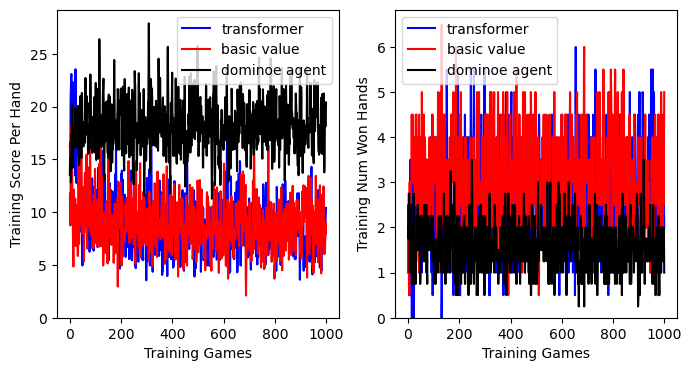

Test winner count:  [18. 32.  0.  0.]
Average score in testing: [ 8.9  7.6 18.2 19.2]


In [22]:
from scipy.signal import savgol_filter

numPlayers = 4
highestDominoe = 9
shuffleAgents = True
defaultAgent = da.dominoeAgent
trainGames = 1000
numRounds = 10
testGames = 50

agents=(da.transformerAgent, da.basicValueAgent, None, None)
game = dg.dominoeGame(highestDominoe, numPlayers=numPlayers, shuffleAgents=shuffleAgents, agents=agents, defaultAgent=defaultAgent, device=device)
game.getAgent(0).setLearning(True)
game.getAgent(0).setReplay(False)
game.getAgent(1).setLearning(True)
game.getAgent(1).setReplay(False)

# run training rounds
trainWinnerCount = np.zeros(numPlayers)
trainHandWinnerCount = np.zeros((trainGames,numPlayers))
trainScoreTally = np.zeros((trainGames,numPlayers))
for gameIdx in tqdm(range(trainGames)):
    game.playGame(rounds=numRounds)
    trainWinnerCount[game.currentWinner] += 1
    trainHandWinnerCount[gameIdx] += np.sum(game.score==0,axis=0)
    trainScoreTally[gameIdx] += game.currentScore

# run testing rounds
with torch.no_grad():
    game.getAgent(0).setLearning(False)
    game.getAgent(1).setLearning(False)
    testWinnerCount = np.zeros(numPlayers)
    testHandWinnerCount = np.zeros((testGames,numPlayers))
    testScoreTally = np.zeros((testGames,numPlayers))
    for gameIdx in tqdm(range(testGames)):
        game.playGame(rounds=numRounds)
        testWinnerCount[game.currentWinner] += 1
        testHandWinnerCount[gameIdx] += np.sum(game.score==0,axis=0)
        testScoreTally[gameIdx] += game.currentScore

filter = lambda x : savgol_filter(x, 2, 1)


fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(range(trainGames), 
           filter(trainScoreTally[:,0]/numRounds), 
           c='b', label="transformer")
ax[0].plot(range(trainGames), 
           filter(trainScoreTally[:,1]/numRounds), 
           c='r', label="basic value")
ax[0].plot(range(trainGames), 
           filter(np.mean(trainScoreTally[:,2:],axis=1)/numRounds),
           c='k', label="dominoe agent")
ax[0].set_ylim(0)
ax[0].set_xlabel('Training Games')
ax[0].set_ylabel('Training Score Per Hand')
ax[0].legend(loc='best')

ax[1].plot(range(trainGames), 
           filter(trainHandWinnerCount[:,0]), 
           c='b', label="transformer")
ax[1].plot(range(trainGames), 
           filter(trainHandWinnerCount[:,1]), 
           c='r', label="basic value")
ax[1].plot(range(trainGames), 
           filter(np.mean(trainHandWinnerCount[:,2:],axis=1)), 
           c='k', label="dominoe agent")
ax[1].set_ylim(0)
ax[1].set_xlabel('Training Games')
ax[1].set_ylabel('Training Num Won Hands')
ax[1].legend(loc='best')

plt.show()

# Print results of experiment
print("Test winner count: ", testWinnerCount)
avgScore = np.round(np.mean(testScoreTally/numRounds,axis=0),1)
print(f"Average score in testing: {avgScore}")


In [129]:
# Code to prepare a curriculum for transformers
from torch import nn

class PointerNetwork(nn.Module):
    """
    pointer network from dominoes/transformers.py with more customization
    """
    def __init__(self, input_dim, embedding_dim, heads=8, expansion=1, kqnorm=True, encoding_layers=1, bias=False, decode_with_gru=True, greedy=False, temperature=1):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.heads = heads
        self.expansion = expansion
        self.kqnorm = kqnorm
        self.bias = bias
        self.encoding_layers = encoding_layers
        self.decoder_method = 'gru' if decode_with_gru else 'attention'
        self.greedy = greedy
        self.temperature = temperature

        self.embedding = nn.Linear(in_features=input_dim, out_features=self.embedding_dim, bias=self.bias)
        self.encodingLayers = nn.ModuleList([transformers.TransformerLayer(self.embedding_dim, heads=self.heads, expansion=self.expansion, 
                                                                           contextual=False, kqnorm=self.kqnorm) for _ in range(self.encoding_layers)])
        self.encoding = self.forwardEncoder # since there are masks, it's easier to write a custom forward than wrangle the transformer layers to work with nn.Sequential
        
        if self.decoder_method == 'gru':
            # if using GRU, then make a GRU cell for the decoder
            self.decoder = nn.GRUCell(input_size=self.embedding_dim, hidden_size=self.embedding_dim, bias=self.bias)
        
        elif self.decoder_method == 'attention':
            # if using attention for the decoder, make a contextual transformer for the decoder
            self.decoder = transformers.TransformerLayer(self.embedding_dim, heads=self.heads, expansion=self.expansion, contextual=True, kqnorm=self.kqnorm)
        
        else: 
            raise ValueError("an unexpected bug occurred and decoder_method was not set correctly"
                             f"it should be either 'gru' or 'attention', but it is {self.decoder_method}")

        # output of the network uses a pointer attention layer as described in the original paper
        self.pointer = transformers.PointerAttention(self.embedding_dim, log_softmax=self.greedy)

        # create simple value network 
        self.value = nn.Linear(in_features=embedding_dim, out_features=1, bias=self.bias)

        # define parameter list 
        self.policyParameters = [*self.embedding.parameters(),
                                 *[prm for elayer in self.encodingLayers for prm in elayer.parameters()],
                                 *self.decoder.parameters(),
                                 *self.pointer.parameters()]
        self.valueParameters = [*self.embedding.parameters(),
                                *[prm for elayer in self.encodingLayers for prm in elayer.parameters()],
                                *self.value.parameters()]

    def forwardEncoder(self, x, mask=None):
        """
        instead of using nn.Sequential just call each layer in sequence
        this solves the problem of passing in the optional mask to the transformer layer 
        (it would have to be passed as an output by the transformer layer and I'd rather keep the transformer layer code clean)
        """
        for elayer in self.encodingLayers:
            x = elayer(x, mask=mask)
        return x
        
    def forward(self, x, mask=None, max_output=None): 
        """
        forward method for pointer network with possible masked input
        
        x should be an input tensor with shape (batchSize, maxTokens, input_dim)
        mask should be a 1/0 input tensor with shape (batchSize, maxTokens) where a 1 indicates a valid token and 0 indicates padded data
        checks on the mask only care about the shape, so make sure your mask is as described!!!

        max_output should be an integer determining when to cut off decoder output
        """
        assert x.ndim == 3, "x must have shape (batch, tokens, input_dim)"
        batch, tokens, inp_dim = x.size()
        assert inp_dim == self.input_dim, "input dim of x doesn't match network"
        if mask is not None: 
            assert mask.ndim == 2, "mask must have shape (batch, tokens)"
            assert mask.size(0)==batch and mask.size(1)==tokens, "mask must have same batch size and max tokens as x"
        else:
            mask = torch.ones((batch, tokens), dtype=x.dtype).to(transformers.get_device(x))

        if max_output is None: 
            max_output = tokens
            
        # Encoding stage
        embeddedRepresentation = self.embedding(x) # embed each token to right dimensionality
        encodedRepresentation = self.encoding(embeddedRepresentation, mask=mask) # perform N-layer self-attention on inputs
        
        # Get the masked mean of any encoded tokens
        numerator = torch.sum(encodedRepresentation*mask.unsqueeze(2), dim=1)
        denominator = torch.sum(mask, dim=1, keepdim=True)
        decoder_context = numerator / denominator
        decoder_input = torch.zeros((batch, self.embedding_dim)).to(transformers.get_device(x)) # initialize decoder_input as zeros

        value = self.value(decoder_context)
        
        # Decoding stage
        pointer_log_scores = []
        pointer_choices = []
        for i in range(max_output):
            # update decoder context using RNN or contextual transformer
            if self.decoder_method == 'gru':
                decoder_context = self.decoder(decoder_input, decoder_context)
            elif self.decoder_method == 'attention':
                contextInputs = torch.cat((decoder_input.unsqueeze(1), encodedRepresentation), dim=1)
                contextMask = torch.cat((torch.ones((batch,1), dtype=mask.dtype).to(transformers.get_device(mask)), mask), dim=1)
                decoder_context = self.decoder((decoder_context.unsqueeze(1), contextInputs), contextMask=contextMask).squeeze(1)
            else:
                raise ValueError("decoder_method not recognized")
                
            # use pointer attention to evaluate scores of each possible input given the context
            score = self.pointer(encodedRepresentation, decoder_context, mask=mask, temperature=self.temperature)
            
            # standard loss function (nll_loss) requires log-probabilities
            log_score = score if self.greedy else torch.log(score)

            # choose token for this sample
            choice = torch.argmax(log_score, dim=1, keepdim=True)

            if self.greedy:
                # next decoder_input is whatever token had the highest probability
                index_tensor = choice.unsqueeze(-1).expand(batch, 1, self.embedding_dim)
                decoder_input = torch.gather(encodedRepresentation, dim=1, index=index_tensor).squeeze(1)
            else:
                # next decoder_input is the dot product of token encodings and their probabilities
                decoder_input = torch.bmm(score.unsqueeze(1), encodedRepresentation).squeeze(1)
                
            # Save output of each decoding round
            pointer_log_scores.append(log_score)
            pointer_choices.append(choice)
            
        pointer_log_scores = torch.stack(pointer_log_scores, 1)
        pointer_choices = torch.stack(pointer_choices, 1).squeeze()

        return pointer_log_scores, pointer_choices, value
        
def randomDominoeHand(numInHand, listDominoes, highestDominoe, null_token=True):
    """method to produce an encoded random hand"""
    numDominoes = len(listDominoes)
    
    # choose dominoes from the batch, and get their value (in points)
    selection = np.random.choice(numDominoes, numInHand, replace=False)

    input = df.twohotDominoe(selection, listDominoes, highestDominoe, withBatch=True)
    if null_token: 
        input_dim = 2*(highestDominoe+1) + (1 if null_token else 0)
        ntoken = torch.zeros((input_dim,), dtype=input.dtype)
        ntoken[-1]=1
        input = torch.cat((input, torch.zeros((1,numInHand,1))), dim=2)
        input = torch.cat((input, ntoken.unsqueeze(0).unsqueeze(0)), dim=1)
    return input, selection

def measureScore(handValues, choices):
    numDominoes = len(handValues)
    nullIdx = numDominoes
    handValues = torch.tensor(handValues)
    totalValue = torch.sum(handValues)

    idxValidChoices = torch.zeros(numDominoes, dtype=torch.bool)
    playValue = torch.tensor([0])
    for i,c in enumerate(choices):
        if c<numDominoes:
            #print(f"Choice: {i} = {handValues[c]}, (choice index: {c})")
            idxValidChoices[c]=True
        if c==nullIdx:
            #print(f"Choice: {i} = null, (choice index: {c})")
            break

    score = torch.sum(handValues[idxValidChoices]) - torch.sum(handValues[~idxValidChoices])
    return score


# --------------- the code to run the problem ----------------------
highestDominoe = 5
dominoes = df.listDominoes(highestDominoe)

batch_size = 1
numInHand = 3
null_token = True

input_dim = 2*(highestDominoe+1) + (1 if null_token else 0)
embedding_dim = 48
heads = 4
expansion = 1
kqnorm = True
encoding_layers = 1
bias = False
decode_with_gru = False
greedy = True
temperature = 5
policy_alpha = 1e-3
value_alpha = 1e-3

net = PointerNetwork(input_dim, embedding_dim, heads=heads, expansion=expansion, kqnorm=kqnorm, encoding_layers=encoding_layers, 
                     bias=bias, decode_with_gru=decode_with_gru, greedy=greedy, temperature=temperature)
net.to(device)

max_output = 2
output_dim = max_output*(numInHand + (1 if null_token else 0))
policyEligibility = [[torch.zeros(prms.shape).to(device) for prms in net.policyParameters] for _ in range(output_dim)]
valueEligibility = [[torch.zeros(prms.shape).to(device) for prms in net.valueParameters] for _ in range(batch_size)]

# run round
epochs = 10000
train_score = torch.zeros((epochs,))
train_value = torch.zeros((epochs,))
net.train()
for e in tqdm(range(epochs)):
    if e > (epochs//2): 
        net.temperature=1
        
    input, selection = randomDominoeHand(numInHand, dominoes, highestDominoe, null_token=null_token)
    input = input.to(device)
    out_scores, out_choice, out_value = net(input, max_output=max_output)
    
    # print("dominoes:", dominoes[selection])
    # print("input:", input)
    # print("choices:", out_choice)
    # print("out_scores:\n", out_scores)
    # print("out_value:", out_value)
    
    # eligibility traces for all parameters given choice scores
    for idx, os in enumerate(out_scores.view(-1)):
        os.backward(retain_graph=True)
        for trace, prms in zip(policyEligibility[idx], net.policyParameters):
            trace += prms.grad
            prms.grad.zero_()
    
    # eilgibility traces for all parameters given value estimate
    for idx, v in enumerate(out_value):
        v.backward(retain_graph=True)
        for trace, prms in zip(valueEligibility[idx], net.valueParameters):
            trace += prms.grad
            prms.grad.zero_()
    
    # grade performance
    score = measureScore(dominoes[selection], out_choice)
    tdError = score - out_value[:,0]

    train_score[e] = score
    train_value[e] = out_value
    
    # update based on score
    with torch.no_grad():
        for idx, td in enumerate(tdError):
            for prmIdx, prms in enumerate(net.policyParameters):
                prms += policy_alpha * policyEligibility[idx][prmIdx] * tdError
    
        for idx, td in enumerate(tdError):
            for prmIdx, prms in enumerate(net.valueParameters):
                prms += value_alpha * valueEligibility[idx][prmIdx] * tdError
    
        for valueEgb in valueEligibility:
            for ve in valueEgb:
                ve *= 0
    
        for policyEgb in policyEligibility:
            for pe in policyEgb:
                pe *= 0

with torch.no_grad():
    net.eval()
    input, selection = randomDominoeHand(numInHand, dominoes, highestDominoe, null_token=null_token)
    input = input.to(device)
    out_scores, out_choice, out_value = net(input, max_output=max_output)
    score = measureScore(dominoes[selection], out_choice)
    
    print("dominoes:", dominoes[selection])
    print("input:", input)
    print("choices:", out_choice)
    print("out_scores:\n", out_scores)
    print("out_value:", out_value)
    print("true score:", score)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [10:21<00:00, 16.09it/s]

dominoes: [[4 4]
 [1 1]
 [1 5]]
input: tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]],
       device='cuda:0')
choices: tensor([1, 1], device='cuda:0')
out_scores:
 tensor([[[-1.7578, -1.1827, -1.2640, -1.4330],
         [-1.7773, -1.1802, -1.2560, -1.4317]]], device='cuda:0')
out_value: tensor([[-9.0257]], device='cuda:0')
true score: tensor(-12)


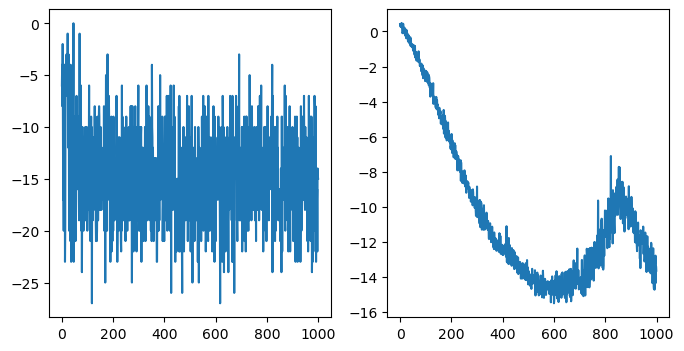

In [128]:
plt.close('all')
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(range(epochs), train_score.detach().cpu().numpy())
ax[1].plot(range(epochs), train_value.detach().cpu().numpy())
plt.show()

In [124]:
print(torch.nn.functional.softmax(torch.arange(5).float(),dim=0))
print(torch.nn.functional.softmax(torch.arange(5).float()/100,dim=0))

tensor([0.0117, 0.0317, 0.0861, 0.2341, 0.6364])
tensor([0.1960, 0.1980, 0.2000, 0.2020, 0.2040])


## Below this point I'm including some code blocks that make inspection of the gameplay and agent status easy... 

In [217]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, da.dominoeAgent, da.bestLineAgent))
game.playGame()
game.printResults()

[[ 5  0 13  7]
 [ 5 11  0  6]
 [ 6  0 49 18]
 [ 7 39 29  0]
 [11 33 20  0]
 [ 6  2 26  0]
 [19 23 17  0]
 [ 0  3 24  7]
 [23 19  0  6]
 [ 7 24 40  0]]
[ 89 154 218  44]
The current winner is agent: 3 with a score of 44!


In [213]:
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None, labelLines=True) #player=game.linePlayer, playNumber=game.linePlayNumber)

player 0:  [' 0|8 ', ' 8|4 ', ' 4|5 ', ' 5|9 ', ' 9|9 ', ' 9|4 ', ' 4|6 ', ' 6|5 ', ' 5|3 ', ' 3|4 ', ' 4|2 ']
player 1:  [' 0|5 ', ' 5|7 ', ' 7|3 ', ' 3|3 ', ' 3|6 ', ' 6|0 ', ' 0|3 ', ' 3|2 ']
player 2:  [' 0|9 ', ' 9|8 ', ' 8|3 ', ' 3|9 ', ' 9|7 ', ' 7|2 ', ' 2|5 ', ' 5|1 ', ' 1|0 ', ' 0|2 ', ' 2|8 ']
player 3:  [' 0|7 ', ' 7|7 ', ' 7|8 ', ' 8|8 ', ' 8|5 ', ' 5|5 ']
dummy:  [' 0|4 ', ' 4|4 ', ' 4|7 ', ' 7|6 ', ' 6|9 ', ' 9|2 ', ' 2|1 ', ' 1|1 ', ' 1|8 ', ' 8|6 ', ' 6|1 ', ' 1|9 ']


In [195]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
game.playHand()
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)

[' 9|7 ', ' 7|8 ', ' 8|5 ', ' 5|5 ']
[' 9|3 ', ' 3|3 ', ' 3|5 ', ' 5|7 ']
[' 9|8 ', ' 8|0 ', ' 0|1 ', ' 1|7 ', ' 7|4 ', ' 4|6 ', ' 6|9 ', ' 9|1 ', ' 1|5 ', ' 5|4 ', ' 4|2 ', ' 2|7 ', ' 7|6 ', ' 6|8 ']
[' 9|5 ', ' 5|6 ', ' 6|6 ', ' 6|0 ', ' 0|0 ', ' 0|9 ', ' 9|4 ', ' 4|8 ', ' 8|1 ']
[' 9|2 ', ' 2|2 ', ' 2|0 ', ' 0|5 ', ' 5|2 ', ' 2|3 ', ' 3|8 ', ' 8|2 ', ' 2|6 ', ' 6|3 ', ' 3|4 ', ' 4|0 ', ' 0|3 ', ' 3|7 ', ' 7|7 ', ' 7|0 ']


In [449]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
lineOptions, dummyOptions = game.agents[0].playOptions()
df.printDominoeList(lineOptions, game.agents[0].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[0].dominoes, name='dummy:')
dominoe, location = game.agents[0].selectPlay()
print(f"Dominoe: {dominoe}, Location: {location}")

line 0: []
line 1: []
line 2: []
line 3: []
dummy: []
Dominoe: None, Location: None


In [207]:
# game details
game.lineSequence

[[], [], [1], []]

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [24:04<00:00, 692.50it/s]


1.4527309322357178


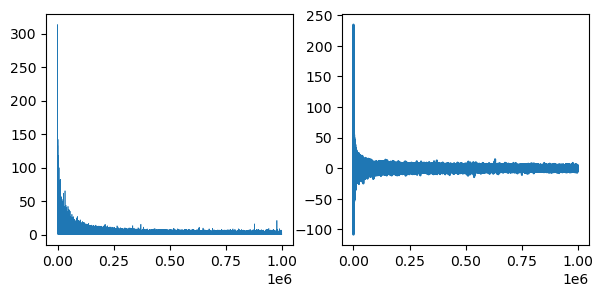

In [159]:
# create random game states and then train a network to predict current hand score...
def generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=False):
    numInHands = np.random.randint(numDominoes+1)
    idxInHands = np.random.choice(numDominoes,numInHands,replace=False)
    handIdx = np.random.randint(0, numPlayers, numInHands)
    played = np.full(numDominoes, True)
    myHand = np.full(numDominoes, False)
    otherHands = np.full(numDominoes, False)
    played[idxInHands]=False
    myHand[idxInHands[handIdx==0]] = True
    otherHands[idxInHands[handIdx>0]] = True
    myHandValue = np.sum(dominoes[myHand])
    otherHandValue = np.sum(dominoes[otherHands])
    if verboseOutput:
        return played, myHand, otherHands, myHandValue, otherHandValue
    networkInput = (np.concatenate((played, myHand))*1)
    networkOutput = np.array([myHandValue, otherHandValue])
    # networkInput = np.concatenate((np.sum(dominoes.T * played, axis=0), np.sum(dominoes.T * myHand, axis=0)))
    return networkInput, networkOutput

# played, myHand, otherHands, myHandValue, otherHandValue = generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=True)
networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)

numPlayers = 3
highestDominoe = 9
numDominoes = df.numberDominoes(highestDominoe)
dominoes = df.listDominoes(highestDominoe)

handValueNetwork = dn.handValueNetwork(numPlayers,numDominoes,highestDominoe)
handValueNetwork.to(device)

numIterations = 1000000
target = np.zeros((numIterations, 2))
pred = np.zeros((numIterations, 2))
storeLoss = np.zeros(numIterations)

lossFunction = nn.L1Loss()
# optimizer = torch.optim.SGD(handValueNetwork.parameters(), lr=1e-2, momentum=0.5)
optimizer = torch.optim.Adadelta(handValueNetwork.parameters())

for ii in tqdm(range(numIterations)):
    networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)
    target[ii] = np.copy(networkOutput)
    
    networkInput = torch.tensor(networkInput).to(device).float()
    networkOutput = torch.tensor(networkOutput).to(device).float()
    
    output = handValueNetwork(networkInput)
    
    loss = lossFunction(output, networkOutput)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    storeLoss[ii] = loss.item()
    pred[ii] = output.detach().cpu().numpy()
    
print(np.mean(storeLoss[-100:]))
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].plot(range(numIterations), storeLoss, linewidth=0.5)
ax[1].plot(range(numIterations), pred[:,0]-target[:,0])

In [ ]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
print(f"Line available: {game.available}, dummy available: {game.dummyAvailable}")
print(f"Penny-up: {game.cantPlay}, dummy playable: {game.dummyPlayable}")
print(f"Hand-size: {game.handSize}, manualHandSize: {[len(agent.myHand) for agent in game.agents]}")
print("")
game.agents[game.nextPlayer].gameState(game.played, game.available, game.handSize, game.cantPlay, game.didntPlay, game.turnCounter, game.dummyAvailable, game.dummyPlayable)
lineOptions, dummyOptions = game.agents[game.nextPlayer].playOptions()
df.printDominoeList(lineOptions, game.agents[game.nextPlayer].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[game.nextPlayer].dominoes, name='dummy:')
dominoe, location = game.agents[game.nextPlayer].selectPlay()
if dominoe is not None:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent played dominoe: {dominoe}: {df.dominoesString(game.dominoes[dominoe])} on location: {location}.")
else:
    print(f"~{game.agents[game.nextPlayer].agentName}~ agent could not play!")
game.doTurn()

In [206]:
print("hello")

hello
